#Setup

In [1]:
from os.path import join
import os
import re

from google.colab import drive

import numpy as np

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2


device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/인지프/PLSU_4064_flip_rotate.zip" -d "/content/"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask2512.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask2512.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask255.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask255.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask533.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask533.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask2274.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask2274.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask3181.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask3181.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask1796.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask1796.jpg  
  inflating: /content/PLSU_4064_flip_rotate/Mask/mask1782.jpg  
  inflating: /content/__MACOSX/PLSU_4064_flip_rotate/Mask/._mask1782.j

# Sorting Data

In [2]:
## 파일 이름에서 숫자 부분을 추출하는 함수
def extract_number(file_name):
    numbers = re.findall(r'\d+', file_name)
    return int(numbers[0]) if numbers else 0


def list_files_in_directory(directory_path):
    items_in_directory = sorted(os.listdir(directory_path))
    files_in_directory = [item for item in items_in_directory if os.path.isfile(os.path.join(directory_path, item))]

    return files_in_directory

In [3]:
# 이미지와 마스크 파일 경로 가져오기 및 정렬
mask_directory = '/content/PLSU_4064_flip_rotate/Mask'
mask_files = list_files_in_directory(mask_directory)
sorted_mask_files = sorted(mask_files, key=extract_number)
print(sorted_mask_files)
print(len(sorted_mask_files))



image_directory = '/content/PLSU_4064_flip_rotate/img'
image_files = list_files_in_directory(image_directory)
sorted_image_files = sorted(image_files, key=extract_number)
print(sorted_image_files)
print(len(sorted_image_files))



# 이미지와 마스크 파일의 전체 경로 생성
image_paths = [os.path.join(image_directory, file_name) for file_name in sorted_image_files]
mask_paths = [os.path.join(mask_directory, file_name) for file_name in sorted_mask_files]



# 이미지와 마스크의 경로 예시를 보고 혹시 파일 리스트가 순서대로 정렬되어 있지 않는지 확인해봅니다.
print(f'이미지 경로 예시 : {image_paths[:5]}')
print(f'마스크 경로 예시 : {mask_paths[:5]}')

['mask1.jpg', 'mask2.jpg', 'mask3.jpg', 'mask4.jpg', 'mask5.jpg', 'mask6.jpg', 'mask7.jpg', 'mask8.jpg', 'mask9.jpg', 'mask10.jpg', 'mask11.jpg', 'mask12.jpg', 'mask13.jpg', 'mask14.jpg', 'mask15.jpg', 'mask16.jpg', 'mask17.jpg', 'mask18.jpg', 'mask19.jpg', 'mask20.jpg', 'mask21.jpg', 'mask22.jpg', 'mask23.jpg', 'mask24.jpg', 'mask25.jpg', 'mask26.jpg', 'mask27.jpg', 'mask28.jpg', 'mask29.jpg', 'mask30.jpg', 'mask31.jpg', 'mask32.jpg', 'mask33.jpg', 'mask34.jpg', 'mask35.jpg', 'mask36.jpg', 'mask37.jpg', 'mask38.jpg', 'mask39.jpg', 'mask40.jpg', 'mask41.jpg', 'mask42.jpg', 'mask43.jpg', 'mask44.jpg', 'mask45.jpg', 'mask46.jpg', 'mask47.jpg', 'mask48.jpg', 'mask49.jpg', 'mask50.jpg', 'mask51.jpg', 'mask52.jpg', 'mask53.jpg', 'mask54.jpg', 'mask55.jpg', 'mask56.jpg', 'mask57.jpg', 'mask58.jpg', 'mask59.jpg', 'mask60.jpg', 'mask61.jpg', 'mask62.jpg', 'mask63.jpg', 'mask64.jpg', 'mask65.jpg', 'mask66.jpg', 'mask67.jpg', 'mask68.jpg', 'mask69.jpg', 'mask70.jpg', 'mask71.jpg', 'mask72.jpg', 

# Custom Dataset

In [ ]:
#No augmentation, test시 이미지만 반환하도록 하는 코드
# class PalmDataset(Dataset):
#     def __init__(self, image_paths, mask_paths, size=(256, 256), mode='train'):
#         self.image_paths = image_paths
#         self.mask_paths = mask_paths
#         self.resize = size
#         self.mode = mode

#         # 기본 변환: 모든 모드에 적용
#         base_transform = [
#             A.Resize(*size),
#             A.Normalize(),
#             ToTensorV2()
#         ]

#         # Train 모드에만 적용될 추가적인 데이터 증강 변환
#         if mode == 'train':
#             self.transform = A.Compose([
#                 # data augmentation 적는 곳
#             ] + base_transform)
#         else:
#             # Validation 및 Test 모드에서는 기본 변환만 적용
#             self.transform = A.Compose(base_transform)

#     def __len__(self):
#         return len(self.image_paths)

#     def __getitem__(self, idx):
#         image = cv2.imread(self.image_paths[idx])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#         if self.mode in ['train', 'val']:
#             mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
#             mask = mask / 255
#             augmented = self.transform(image=image, mask=mask)
#             return augmented['image'], augmented['mask']
#         else:
#             # 테스트 모드에서는 마스크 없이 이미지만 반환
#             return self.transform(image=image)['image']

In [4]:
from torch.utils.data import Dataset
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

class PalmDataset(Dataset):
    def __init__(self, image_paths, mask_paths, size=(256, 256), mode='train'):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.resize = size
        self.mode = mode

        # 기본 변환: 모든 모드에 적용
        base_transform = [
            A.Resize(*size),
            A.Normalize(),
            ToTensorV2()
        ]

        transform = [
            A.Resize(*size),
            ToTensorV2()
        ]
        self.normal_transform = A.Compose(transform)

        # Train 모드에만 적용될 추가적인 데이터 증강 변환
        if mode == 'train':
            self.transform = A.Compose([
                # data augmentation 적는 곳
            ] + base_transform)
        else:
            # Validation 및 Test 모드에서는 기본 변환만 적용
            self.transform = A.Compose(base_transform)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
        mask = mask / 255  # Normalize the mask to be [0, 1]

        # 변환 적용
        augmented = self.transform(image=image, mask=mask)
        augmented2 = self.normal_transform(image=image, mask=mask)
        return augmented['image'], augmented['mask'], augmented2['image']


# Data Lodaer

In [5]:
#train:val:test = 75%:15%:15%
train_image_paths, test_image_paths, train_mask_paths, test_mask_paths = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)
test_image_paths, val_image_paths, test_mask_paths, val_mask_paths = train_test_split(test_image_paths, test_mask_paths, test_size=0.5, random_state=42)

train_dataset = PalmDataset(train_image_paths, train_mask_paths, size=(256,256),mode='train')
val_dataset = PalmDataset(val_image_paths, val_mask_paths, size=(256,256),mode='val')
test_dataset = PalmDataset(test_image_paths, test_mask_paths, size=(256,256),mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

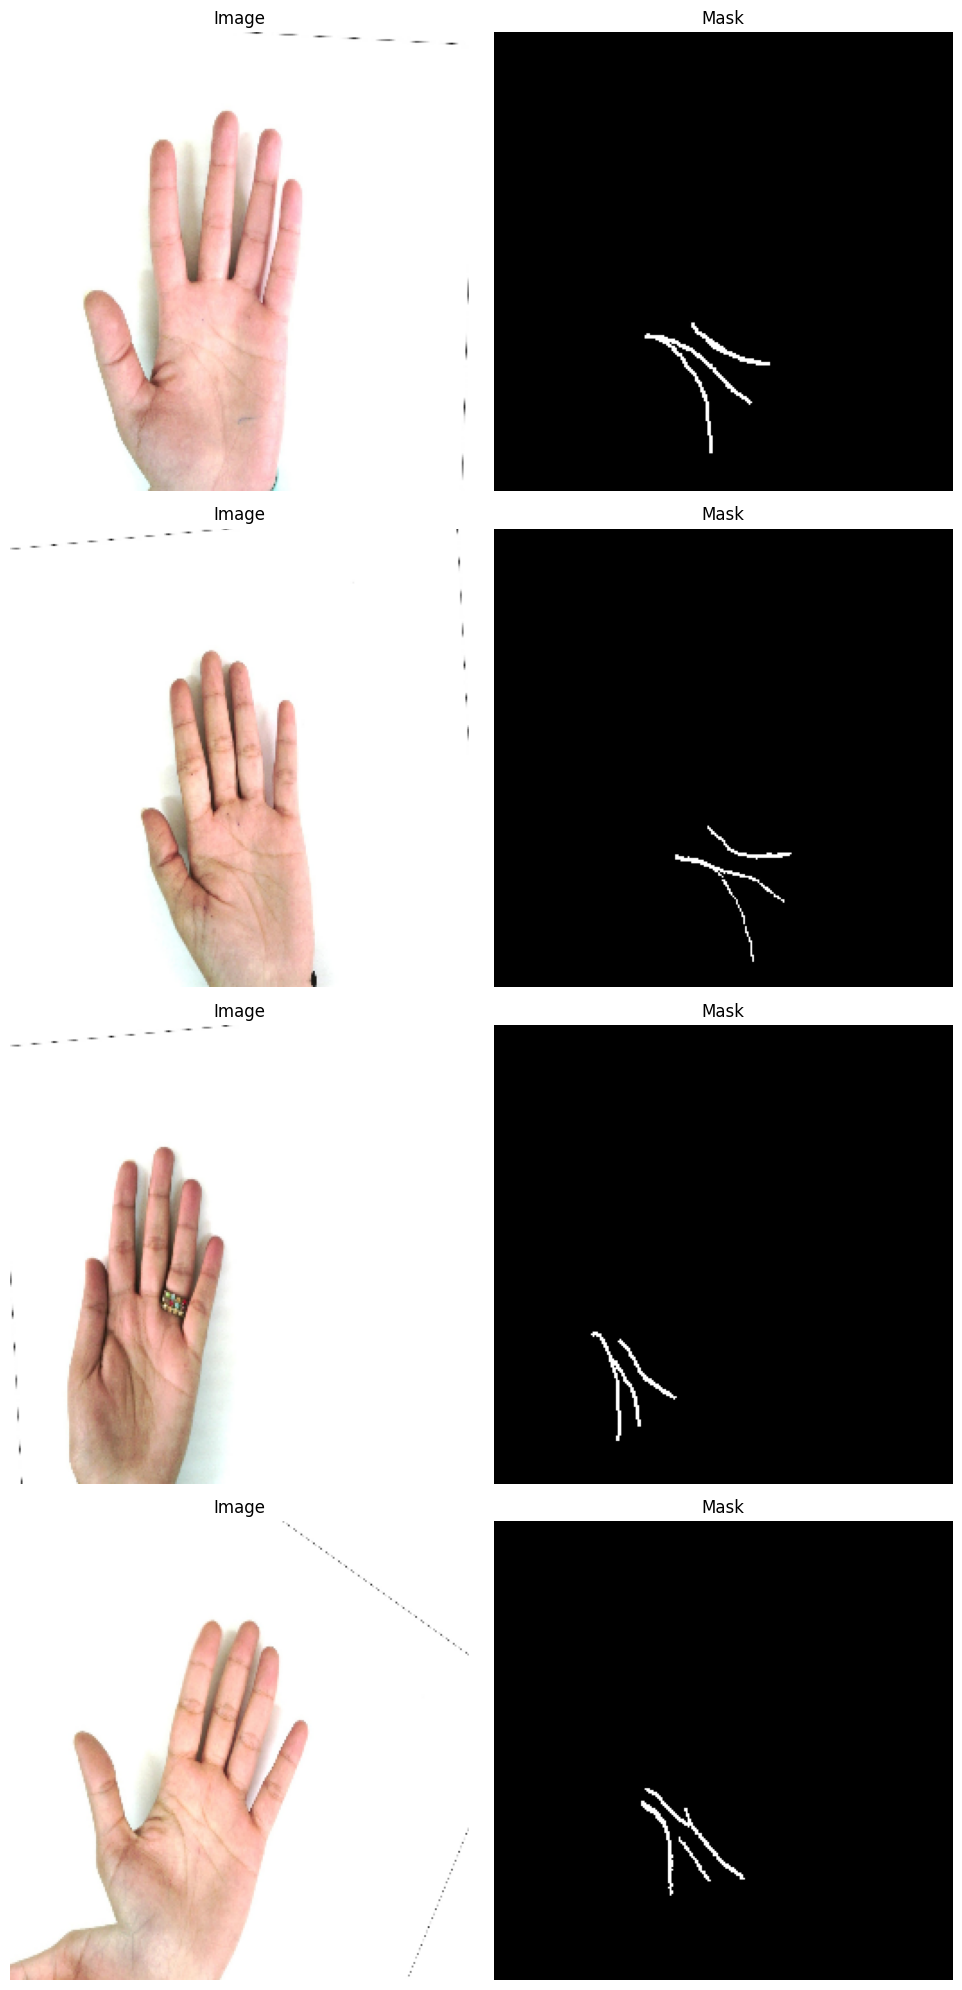

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 첫 번째 배치 가져오기
images, masks, images_ = next(iter(train_loader))

# 이미지와 마스크 시각화
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
for i in range(4):
    ax[i, 0].imshow(images_[i].permute(1, 2, 0))  # 이미지
    ax[i, 1].imshow(masks[i], cmap='gray')  # 마스크
    ax[i, 0].set_title("Image")
    ax[i, 1].set_title("Mask")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Define Model

In [6]:
vgg = torchvision.models.vgg16_bn(pretrained=True)

class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
        elif upsampling_method == "bilinear":
            self.upsample = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            )
        self.double_conv = nn.Sequential(
              nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True),
              nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ReLU(inplace=True)
          )

    def forward(self, up_x, down_x):
        """

        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.double_conv(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 5

    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.vgg = torchvision.models.vgg16_bn(pretrained=True)
        down_blocks = []
        up_blocks = []

        # 입력 채널을 n_channels로 조정
        '''
        self.input_block = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            self.vgg.features[:6]
        )
        '''

        self.block1 = nn.Sequential(self.vgg.features[:6])
        self.block2 = nn.Sequential(self.vgg.features[6:13])
        self.block3 = nn.Sequential(self.vgg.features[13:20])
        self.block4 = nn.Sequential(self.vgg.features[20:27])
        self.block5 = nn.Sequential(self.vgg.features[27:34])

        self.bottleneck = nn.Sequential(self.vgg.features[34:])

        self.bridge = double_conv(512, 1024)

        self.upblock6 = UpBlockForUNetWithResNet50(1024, 512)
        self.upblock7 = UpBlockForUNetWithResNet50(256 + 512, 256, 512, 256)
        self.upblock8 = UpBlockForUNetWithResNet50(128 + 256, 128, 256, 128)
        self.upblock9 = UpBlockForUNetWithResNet50(64 + 128, 64, 128, 64)
        self.upblock10 = UpBlockForUNetWithResNet50(32 + 64, 32, 64, 32)

        self.out = nn.Conv2d(32, n_classes, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)


        bottleneck = self.bottleneck(block5)
        x = self.bridge(bottleneck)

        x = self.upblock6(x, block5)
        x = self.upblock7(x, block4)
        x = self.upblock8(x, block3)
        x = self.upblock9(x, block2)
        x = self.upblock10(x, block1)


        output_feature_map = x
        x = self.out(x)
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:02<00:00, 202MB/s]


#Evaluate

In [7]:
# F-1 Score와 IoU 계산을 위한 함수
def calculate_f1_score(preds, labels):
    # 시그모이드 함수를 적용하여 확률로 변환
    preds = torch.sigmoid(preds)
    # 확률을 이진화 (0.5를 임계값으로 사용)
    preds = (preds > 0.5).float()

    # True Positives, False Positives, False Negatives 계산
    tp = (preds * labels).sum(dim=[1, 2, 3])
    fp = (preds * (1 - labels)).sum(dim=[1, 2, 3])
    fn = ((1 - preds) * labels).sum(dim=[1, 2, 3])

    # F1 Score 계산
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)

    # 배치 내 모든 이미지에 대한 F1 Score의 평균 반환
    return f1.mean().item()

def calculate_iou(preds, labels):
    # 시그모이드 함수를 적용하여 확률로 변환
    preds = torch.sigmoid(preds)
    # 확률을 이진화 (0.5를 임계값으로 사용)
    preds = (preds > 0.5).float()

    # True Positives, False Positives, False Negatives 계산
    intersection = (preds * labels).sum(dim=[1, 2, 3])  # 교집합
    total = (preds + labels).sum(dim=[1, 2, 3])  # 합집합
    union = total - intersection  # 합집합 - 교집합

    # IoU 계산
    iou = (intersection + 1e-6) / (union + 1e-6)  # 0으로 나누는 것을 방지하기 위한 작은 값 추가

    # 배치 내 모든 이미지에 대한 IoU의 평균 반환
    return iou.mean().item()


# Loss function

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # inputs : 모델 출력, targets : 실제 마스크
        inputs = torch.sigmoid(inputs)  # 시그모이드 함수를 적용하여 확률로 변환

        # 평탄화
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Dice 계수 계산
        intersection = (inputs * targets).sum()
        dice = (2.*intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)

        # Dice 손실
        return 1 - dice

In [9]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

#Train

100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 1, Loss: 0.9766108762012439, Validation Loss: 0.9652807861566544, Avg F-1: 0.3672087073326111, mIoU: 0.22701701372861863


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 2, Loss: 0.8799907210167874, Validation Loss: 0.8635733813047409, Avg F-1: 0.6946144431829453, mIoU: 0.5351443737745285


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 3, Loss: 0.5362808958867963, Validation Loss: 0.47192121744155885, Avg F-1: 0.714793449640274, mIoU: 0.5593688398599624


100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Epoch 4, Loss: 0.4407236957817935, Validation Loss: 0.4356196641921997, Avg F-1: 0.7317208260297775, mIoU: 0.5797889024019242


100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Epoch 5, Loss: 0.4213958362515053, Validation Loss: 0.42044801115989683, Avg F-1: 0.735298952460289, mIoU: 0.583919683098793


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 6, Loss: 0.41075211093666847, Validation Loss: 0.41132519245147703, Avg F-1: 0.742518863081932, mIoU: 0.5929030179977417


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 7, Loss: 0.40454218159900623, Validation Loss: 0.41074854135513306, Avg F-1: 0.7420523732900619, mIoU: 0.5924020051956177


100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch 8, Loss: 0.3989971045697673, Validation Loss: 0.412294414639473, Avg F-1: 0.7390025645494461, mIoU: 0.5884899824857712


100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


Epoch 9, Loss: 0.3948644359460038, Validation Loss: 0.4112825870513916, Avg F-1: 0.7402071833610535, mIoU: 0.5902965217828751


100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


Epoch 10, Loss: 0.3904339430037509, Validation Loss: 0.4069517344236374, Avg F-1: 0.7432328194379807, mIoU: 0.5939019680023193


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 11, Loss: 0.38622683152723847, Validation Loss: 0.40322495102882383, Avg F-1: 0.745762899518013, mIoU: 0.5971423089504242


100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


Epoch 12, Loss: 0.38350365135107145, Validation Loss: 0.4054493486881256, Avg F-1: 0.7448116779327393, mIoU: 0.5960623294115066


100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Epoch 13, Loss: 0.3802229246396697, Validation Loss: 0.4052814841270447, Avg F-1: 0.7442979007959366, mIoU: 0.5952252894639969


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 14, Loss: 0.37817634290523744, Validation Loss: 0.39675659537315366, Avg F-1: 0.7511458843946457, mIoU: 0.6038409173488617


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 15, Loss: 0.37160841266760664, Validation Loss: 0.396673372387886, Avg F-1: 0.7508905857801438, mIoU: 0.6035922706127167


100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Epoch 16, Loss: 0.3675364222419396, Validation Loss: 0.396392947435379, Avg F-1: 0.7506681442260742, mIoU: 0.6036214113235474


100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Epoch 17, Loss: 0.36419596096103113, Validation Loss: 0.39663648307323457, Avg F-1: 0.7507822513580322, mIoU: 0.6035341203212738


100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch 18, Loss: 0.3607411150182231, Validation Loss: 0.3965743720531464, Avg F-1: 0.7509102791547775, mIoU: 0.6035852640867233


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 19, Loss: 0.35739643453212266, Validation Loss: 0.39527417421340943, Avg F-1: 0.7517004132270813, mIoU: 0.6046331286430359


100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


Epoch 20, Loss: 0.35342566953616195, Validation Loss: 0.3973059892654419, Avg F-1: 0.7496904999017715, mIoU: 0.6022491216659546


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 21, Loss: 0.34987790330072466, Validation Loss: 0.3950567305088043, Avg F-1: 0.7512950986623764, mIoU: 0.6042630106210709


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 22, Loss: 0.34606351142518976, Validation Loss: 0.39569039046764376, Avg F-1: 0.7509785652160644, mIoU: 0.603947326540947


100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


Epoch 23, Loss: 0.3409912673275122, Validation Loss: 0.39481455385684966, Avg F-1: 0.7516467690467834, mIoU: 0.6047350168228149


100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Epoch 24, Loss: 0.3379610689838281, Validation Loss: 0.393391016125679, Avg F-1: 0.7527306765317917, mIoU: 0.6061496019363404


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 25, Loss: 0.33415198593996887, Validation Loss: 0.39616485238075255, Avg F-1: 0.750671061873436, mIoU: 0.6033963859081268


100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


Epoch 26, Loss: 0.32981323325232176, Validation Loss: 0.39780664145946504, Avg F-1: 0.7499349921941757, mIoU: 0.6025279760360718


100%|██████████| 20/20 [00:10<00:00,  1.97it/s]


Epoch 27, Loss: 0.32559310653236473, Validation Loss: 0.3969994902610779, Avg F-1: 0.7497841030359268, mIoU: 0.6025042772293091


100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


Epoch 28, Loss: 0.3207072126731444, Validation Loss: 0.3948867291212082, Avg F-1: 0.7514437347650528, mIoU: 0.604402819275856


100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Epoch 29, Loss: 0.31613181079371594, Validation Loss: 0.39921623170375825, Avg F-1: 0.7479361563920974, mIoU: 0.6000992804765701


100%|██████████| 20/20 [00:10<00:00,  1.95it/s]


Epoch 30, Loss: 0.3126181290390786, Validation Loss: 0.39674873650074005, Avg F-1: 0.7501199007034302, mIoU: 0.6028121799230576


100%|██████████| 20/20 [00:10<00:00,  1.93it/s]


Epoch 31, Loss: 0.30745680680435694, Validation Loss: 0.39804730713367464, Avg F-1: 0.748429000377655, mIoU: 0.6008183985948563


100%|██████████| 20/20 [00:10<00:00,  1.94it/s]


Epoch 32, Loss: 0.3026854790998309, Validation Loss: 0.39891756176948545, Avg F-1: 0.7483601748943329, mIoU: 0.6006421923637391


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


Epoch 33, Loss: 0.29732882440759895, Validation Loss: 0.4012663871049881, Avg F-1: 0.7460030347108841, mIoU: 0.5977767109870911


100%|██████████| 20/20 [00:10<00:00,  1.98it/s]


Epoch 34, Loss: 0.2926308385441812, Validation Loss: 0.40079099535942075, Avg F-1: 0.7464201539754868, mIoU: 0.5982651442289353
Early stopping triggered


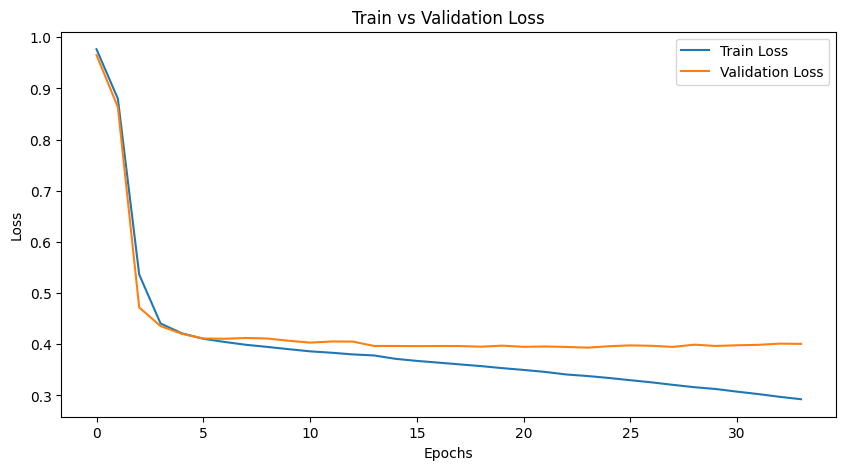

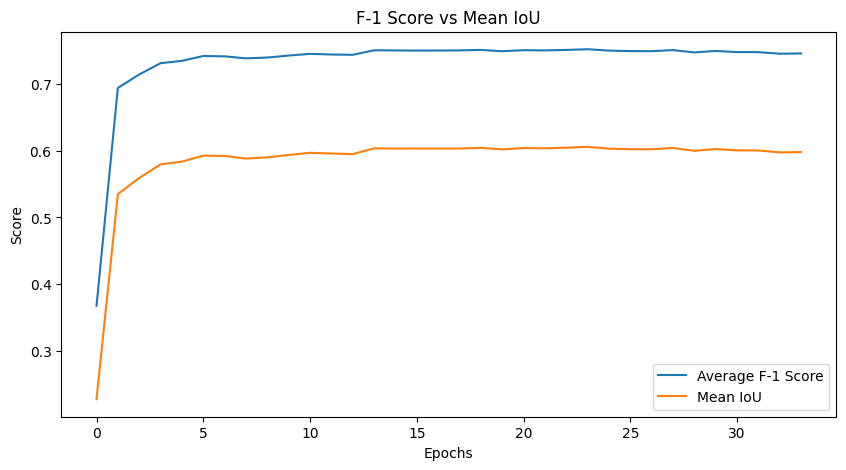

In [10]:
import matplotlib.pyplot as plt

# 성능 기록을 위한 리스트 초기화
train_losses = []
val_losses = []
f1_scores_epochs = []
iou_scores_epochs = []



#하이퍼 파라미터
num_epochs = 50
learning_rate = 0.001
T_max = 50  # 학습률 주기

# 최상의 모델을 저장하기 위한 초기 설정
best_iou_score = 0.0
early_stopping_counter = 0
patience = 10  # 성능이 개선되지 않는 에포크 한계값

# model 초기화
model = UNetWithResnet50Encoder(n_channels=3, n_classes=1).to(device)
model = model.to(device)

#loss function과 optimizer 정리
criterion = smp.losses.JaccardLoss(mode='binary')
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4, amsgrad=False)

# CosineAnnealingLR 스케줄러 초기화
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=1e-6)

# training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for images, masks, _ in tqdm(train_loader):
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)


        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #Learning Rate 조정
    scheduler.step()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation loop
    model.eval()
    val_loss = 0
    iou_scores = []
    f1_scores = []
    with torch.no_grad():
        for images, masks, _ in tqdm(val_loader):  # val_loader는 검증 데이터셋에 대한 DataLoader입니다.
            images = images.float().to(device)
            masks = masks.float().to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # F-1 Score와 IoU 계산
            f1 = calculate_f1_score(outputs, masks)
            iou = calculate_iou(outputs, masks)
            f1_scores.append(f1)
            iou_scores.append(iou)

    # 평균 IoU 및 손실 계산
    val_loss /= len(val_loader)
    avg_f1 = np.mean(f1_scores)
    avg_iou = np.mean(iou_scores)
    val_losses.append(val_loss)
    f1_scores_epochs.append(avg_f1)
    iou_scores_epochs.append(avg_iou)


    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}, Validation Loss: {val_loss}, Avg F-1: {avg_f1}, mIoU: {avg_iou}')

    # Early Stopping
    if avg_iou > best_iou_score:
        best_iou_score = avg_iou
        early_stopping_counter = 0
        # 가장 좋은 모델 저장
        torch.save(model.state_dict(), '/content/drive/MyDrive/인지프/checkpoints/best_model_vgg16.pth')
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

# 학습 및 검증 손실 그래프
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.show()

# F-1 Score와 mIoU Score 그래프
plt.figure(figsize=(10, 5))
plt.plot(f1_scores_epochs, label='Average F-1 Score')
plt.plot(iou_scores_epochs, label='Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('F-1 Score vs Mean IoU')
plt.legend()
plt.show()

#Test

In [11]:
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split
from PIL import Image

In [13]:
model.load_state_dict(torch.load('/content/drive/MyDrive/인지프/checkpoints/best_model_vgg16.pth'))

<All keys matched successfully>

In [14]:
#evaluate Test
# 모델을 평가 모드로 설정
model.eval()

# 점수 초기화
total_f1_score = 0.0
total_iou_score = 0.0
num_samples = 0

# 테스트 데이터셋에 대한 루프
for images, masks, _ in test_loader:
    with torch.no_grad():
        # 데이터를 장치에 로드
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)

        # 모델 예측
        outputs = model(images)

        # F1 점수와 IoU 점수 계산
        f1 = calculate_f1_score(outputs, masks)
        iou = calculate_iou(outputs, masks)
        total_f1_score += f1
        total_iou_score += iou
        num_samples += 1

# 평균 F1 점수와 IoU 점수 출력
avg_f1_score = total_f1_score / num_samples
avg_iou_score = total_iou_score / num_samples
print(f"Average F1 Score on Test Set: {avg_f1_score}")
print(f"Average IoU Score on Test Set: {avg_iou_score}")

Average F1 Score on Test Set: 0.748878338932991
Average IoU Score on Test Set: 0.6011378854513169


#Test 1 | f1: 0.7454826831817627, iou: 0.59666508436203


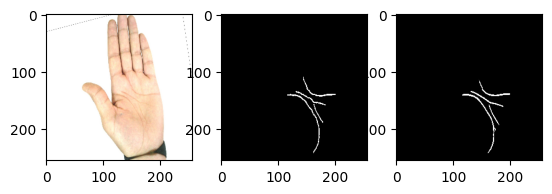

#Test 2 | f1: 0.7412247061729431, iou: 0.5910964608192444


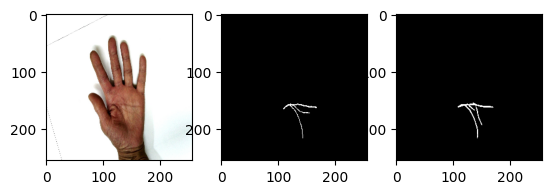

#Test 3 | f1: 0.7523866295814514, iou: 0.6055729389190674


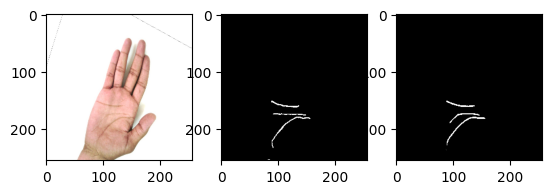

#Test 4 | f1: 0.7444591522216797, iou: 0.5965110063552856


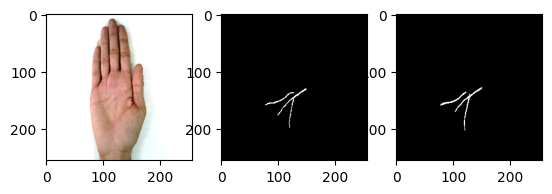

#Test 5 | f1: 0.7647871971130371, iou: 0.6218372583389282


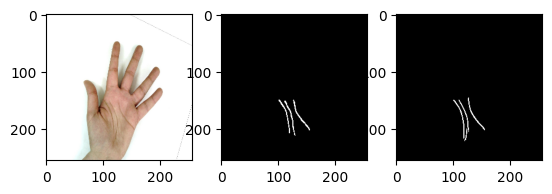

#Test 6 | f1: 0.7459036111831665, iou: 0.5971307754516602


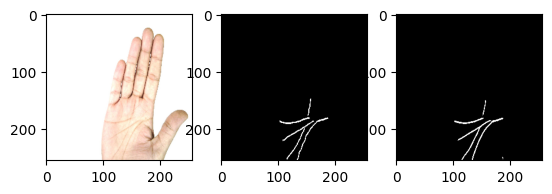

#Test 7 | f1: 0.752781867980957, iou: 0.6069124937057495


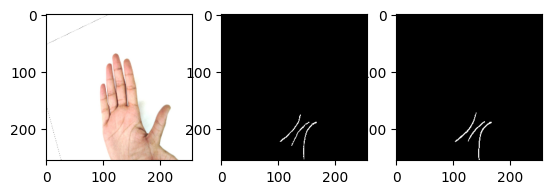

#Test 8 | f1: 0.7573782205581665, iou: 0.6121556758880615


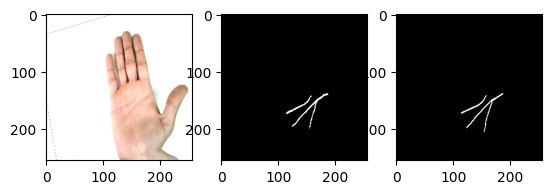

#Test 9 | f1: 0.7397492527961731, iou: 0.5896202325820923


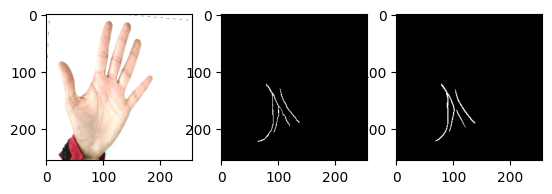

#Test 10 | f1: 0.7481718063354492, iou: 0.6003715395927429


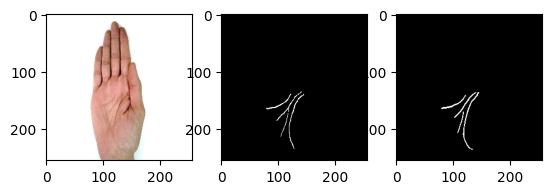

In [15]:
#Print Test Mask
model.eval()

k = 1
f1_scores = []
iou_scores = []
for images, masks, real in test_loader:
    if k > 10:
        break
    with torch.no_grad():
        images = images.float().to(device)
        masks = masks.float().to(device).unsqueeze(1)
        outputs = model(images)

        # F1와 IoU 계산
        f1 = calculate_f1_score(outputs, masks)
        iou = calculate_iou(outputs, masks)
        f1_scores.append(f1)
        iou_scores.append(iou)

        print(f"#Test {k} | f1: {f1}, iou: {iou}")

        # 시각화
        img_cpu = real[0].cpu().numpy().transpose(1, 2, 0)  # 첫 번째 이미지 선택
        mask_cpu = masks[0].squeeze().cpu().numpy()           # 첫 번째 마스크 선택
        output_sigmoid = torch.sigmoid(outputs[0]).squeeze().cpu().numpy()  # 첫 번째 출력 선택, 채널 차원 제거
        plt.subplot(1, 3, 1)
        plt.imshow(img_cpu)
        plt.subplot(1, 3, 2)
        plt.imshow(mask_cpu, cmap='gray')
        plt.subplot(1, 3, 3)
        plt.imshow(output_sigmoid, cmap='gray')
        plt.show()
        k += 1

#Experiments

In [ ]:
pip install pyheif

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 12.4 MB/s eta 0:00:00


In [ ]:
import pyheif

In [ ]:
def heic_to_jpeg(heic_dir, jpeg_dir):

    heif_file = pyheif.read(heic_dir)

    image = Image.frombytes(
        heif_file.mode,
        heif_file.size,
        heif_file.data,
        "raw",
        heif_file.mode,
        heif_file.stride
        )

    print(heif_file)
    image.save(jpeg_dir,"JPEG")

In [ ]:
heic_to_jpeg("/content/IMG_5076.heic", "/content/IMG_5076.jpeg")

<HeifFile 2806x3787 RGB with 31931984 bytes data>


In [ ]:
# 단일 이미지에 대한 전처리 및 데이터 증강을 수행하는 함수
def preprocess_image(img_path, size=(256, 256)):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 데이터 증강 및 전처리 파이프라인
    transform = A.Compose([
        A.Resize(*size),
        A.Normalize(),
        ToTensorV2()
    ])

    # 변환 적용
    transformed = transform(image=image)
    return transformed['image']

In [ ]:
# 단일 이미지를 검출하는 함수
def detect(jpeg_dir, model, device, save=True):
    # 이미지 전처리
    image = preprocess_image(jpeg_dir)

    # 모델 예측
    with torch.no_grad():
        image = image.float().unsqueeze(0).to(device)
        outputs = model(image)

    # 시각화
    pil_img = Image.open(jpeg_dir).convert('RGB').resize((256, 256), resample=Image.NEAREST)
    img_cpu = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    output_sigmoid = torch.sigmoid(outputs).squeeze(0).cpu().numpy().squeeze()  # 첫 번째 차원 제거

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(pil_img)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(output_sigmoid, cmap='gray')  # 2차원 배열
    plt.title('Predicted Mask')
    plt.show()

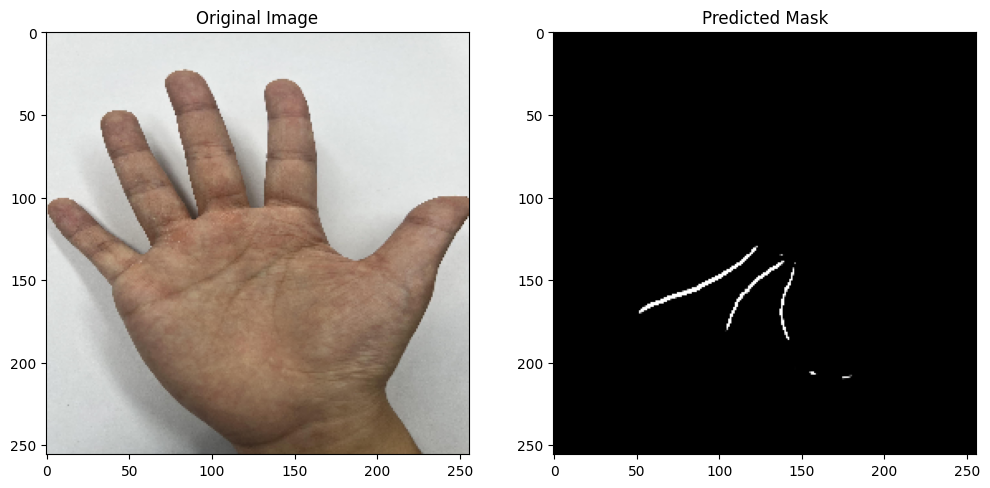

In [ ]:
detect("/content/IMG_5076.jpeg",model,device)

In [ ]:
detect("./inputs/hand2_1.jpeg")
detect("./inputs/hand2_2.jpeg")
detect("./inputs/hand2_3.jpg")
detect("./inputs/hand2_4.jpg")

In [ ]:
detect("./inputs/hand4_1.jpeg")
detect("./inputs/hand4_2.jpeg")
detect("./inputs/hand4_3.jpg")
detect("./inputs/hand4_4.jpg")